In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import adjusted_rand_score
import itertools

os.makedirs("artifacts/figures", exist_ok=True)
global_dic = {}

Функции для KMEANS

In [31]:
def plot_2d_points(X, labels=None, centers=None, title=None, save_name=None):
    # Рисует 2D-точки.
    # - X: массив формы (n_samples, 2)
    # - labels: метки кластеров (если есть)
    # - centers: центры кластеров (если есть)
    if X.shape[1] != 2:
        raise ValueError("plot_2d_points ожидает X с двумя признаками (n_samples, 2).")

    plt.figure(figsize=(7, 5))
    if labels is None:
        plt.scatter(X[:, 0], X[:, 1], s=25)
    else:
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=25)

    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], marker="X", s=220, edgecolor="k")

    if title:
        plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True, alpha=0.25)
    if save_name:
        plt.savefig(f"artifacts/figures/{save_name}.png")
    plt.show()

    
def plot_k_metrics(metrics, title_suffix=""):
    k = metrics["k"]
    inertia = metrics["inertia"]
    sil = metrics["silhouette"]

    plt.figure(figsize=(7, 4))
    plt.plot(k, inertia, marker="o")
    plt.title(f"Inertia vs K{title_suffix}")
    plt.xlabel("K")
    plt.ylabel("inertia_ (ниже лучше)")
    plt.grid(True, alpha=0.25)

    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(k, sil, marker="o")
    plt.title(f"Silhouette vs K{title_suffix}")
    plt.xlabel("K")
    plt.ylabel("silhouette (выше лучше)")
    plt.grid(True, alpha=0.25)
    plt.show()

def evaluate_k_range(X, k_values, random_state=42):
    X_work = X
    inertias = []
    silhouettes = []

    for k in k_values:
        model = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = model.fit_predict(X_work)

        inertias.append(model.inertia_)

        if k >= 2 and len(np.unique(labels)) > 1:
            silhouettes.append(silhouette_score(X_work, labels))
        else:
            silhouettes.append(np.nan)

    return {
        "k": np.array(list(k_values), dtype=int),
        "inertia": np.array(inertias, dtype=float),
        "silhouette": np.array(silhouettes, dtype=float),
    }


def plot_k_metrics(metrics, title_suffix=""):
    k = metrics["k"]
    inertia = metrics["inertia"]
    sil = metrics["silhouette"]

    plt.figure(figsize=(7, 4))
    plt.plot(k, inertia, marker="o")
    plt.title(f"Inertia vs K{title_suffix}")
    plt.xlabel("K")
    plt.ylabel("inertia_ (ниже лучше)")
    plt.grid(True, alpha=0.25)
    plt.savefig(f"artifacts/figures/inertia_vs_k{title_suffix}.png")
    plt.show() 
    

    plt.figure(figsize=(7, 4))
    plt.plot(k, sil, marker="o")
    plt.title(f"Silhouette vs K{title_suffix}")
    plt.xlabel("K")
    plt.ylabel("silhouette (выше лучше)")
    plt.grid(True, alpha=0.25)
    plt.savefig(f"artifacts/figures/silhouette_vs_k{title_suffix}.png")
    plt.show()
    

def check_stability(X, k, n_runs=5):
    labels_list = []
    
    for i in range(n_runs):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=i)
        kmeans.fit(X)
        labels_list.append(kmeans.labels_)
    
    ari_scores = []
    for l1, l2 in itertools.combinations(labels_list, 2):
        score = adjusted_rand_score(l1, l2)
        ari_scores.append(score)
        
    mean_ari = np.mean(ari_scores)
    std_ari = np.std(ari_scores)
    
    return mean_ari, std_ari

Функции для DBSCAN

In [32]:
def plot_dbscan(X, labels, title="", ax=None, save_name=None):
    """Визуализация результата DBSCAN: кластеры + шум."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))

    labels = np.asarray(labels)
    unique = sorted(set(labels))

    for lab in unique:
        mask = labels == lab
        if lab == -1:
            ax.scatter(X[mask, 0], X[mask, 1], s=20, marker="x", label="noise (-1)")
        else:
            ax.scatter(X[mask, 0], X[mask, 1], s=20, label=f"cluster {lab}")

    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.grid(True, alpha=0.25)
    ax.legend(loc="best")
    if save_name:
        plt.savefig(f"artifacts/figures/{save_name}", bbox_inches='tight')
        print(f"График сохранен: artifacts/figures/{save_name}")
    return ax

def summarize_labels(labels):
    """Короткая статистика по разметке: число кластеров, доля шума."""
    labels = np.asarray(labels)
    n_noise = np.sum(labels == -1)
    n_points = len(labels)
    clusters = sorted([c for c in set(labels) if c != -1])
    return {
        "n_points": n_points,
        "n_clusters": len(clusters),
        "n_noise": int(n_noise),
        "noise_share": float(n_noise / n_points)
    }

def safe_internal_metrics(X, labels):
    """Внутренние метрики для кластеров.

    Важно:
    - silhouette корректно считать, когда есть >=2 кластера.
    - шум (-1) лучше исключать из расчёта, иначе метрика становится трудно интерпретируемой.
    """
    labels = np.asarray(labels)
    mask = labels != -1
    X2 = X[mask]
    y2 = labels[mask]

    result = {}

    # если осталось меньше 2 кластеров – метрики бессмысленны
    if len(set(y2)) < 2:
        result["silhouette"] = None
        result["calinski_harabasz"] = None
        result["davies_bouldin"] = None
        return result

    result["silhouette"] = float(silhouette_score(X2, y2))
    result["calinski_harabasz"] = float(calinski_harabasz_score(X2, y2))
    result["davies_bouldin"] = float(davies_bouldin_score(X2, y2))
    return result

def k_distance_plot(X, k=8, title="k-distance plot"):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)  # distances shape: (n_samples, k)

    kth = np.sort(distances[:, -1])  # расстояние до k-го соседа
    plt.figure(figsize=(7, 4))
    plt.plot(kth)
    plt.title(f"{title} (k={k})")
    plt.xlabel("sorted points index")
    plt.ylabel(f"distance to {k}-th nearest neighbor")
    plt.grid(True, alpha=0.25)
    plt.show()

    return kth

In [33]:
ds1 = pd.read_csv(r"data/S07-hw-dataset-01.csv")
ds2 = pd.read_csv(r"data/S07-hw-dataset-02.csv")
ds3 = pd.read_csv(r"data/S07-hw-dataset-03.csv")

In [34]:
print(ds1.head(5))
ds1.info()

   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04 

In [35]:
ds1.describe()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


In [36]:
print(ds2.head(5))
ds2.info()

   sample_id        x1        x2    z_noise
0          0  0.098849 -1.846034  21.288122
1          1 -1.024516  1.829616   6.072952
2          2 -1.094178 -0.158545 -18.938342
3          3 -1.612808 -1.565844 -11.629462
4          4  1.659901 -2.133292   1.895472
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


In [37]:
ds2.describe()

,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


In [38]:
print(ds3.head(5))
ds3.info()

   sample_id        x1        x2    f_corr   f_noise
0          0 -2.710470  4.997107 -1.015703  0.718508
1          1  8.730238 -8.787416  3.953063 -1.105349
2          2 -1.079600 -2.558708  0.976628 -3.605776
3          3  6.854042  1.560181  1.760614 -1.230946
4          4  9.963812 -8.869921  2.966583  0.915899
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB


In [39]:
ds3.describe()

,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865


In [40]:
def preprocess_data(df):
    """
    Принимает датафрейм, выполняет предобработку:
    1. Заполняет пропуски.
    2. Масштабирует числа (StandardScaler).
    3. Кодирует категории (OneHotEncoder).
    
    Возвращает: обработанный DataFrame и сам объект препроцессора.
    """
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = df.select_dtypes(include=['object', 'category']).columns
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        verbose_feature_names_out=False 
    )

    preprocessor.set_output(transform="pandas")
    df_processed = preprocessor.fit_transform(df)
    
    return df_processed

In [41]:
processed_ds1 = preprocess_data(ds1)
processed_ds2 = preprocess_data(ds2)
processed_ds3 = preprocess_data(ds3)

Датасет 1


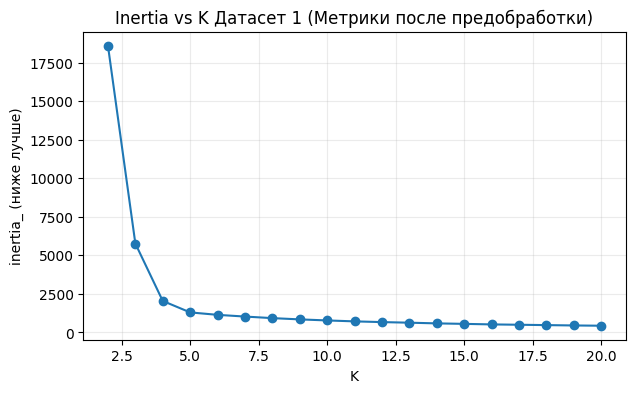

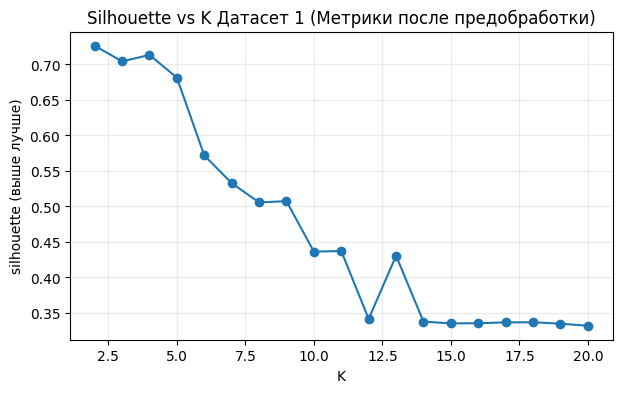

In [42]:
k_values = list(range(2, 21))
pca = PCA(n_components=2)
X_2d = pca.fit_transform(processed_ds1)

metrics_scaled = evaluate_k_range(X_2d, k_values, random_state=42)
plot_k_metrics(metrics_scaled, title_suffix=" Датасет 1 (Метрики после предобработки)")

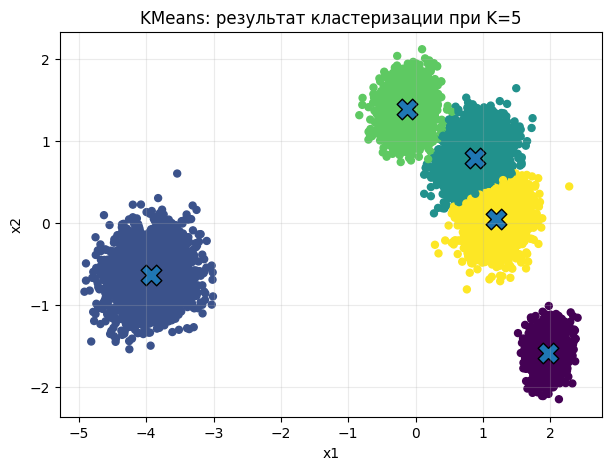

inertia_ = 1282.63
Число найденных кластеров = 5
Внутренние метрики: {'silhouette': 0.2843556008772226, 'calinski_harabasz': 5453.960303449328, 'davies_bouldin': 1.6822021166601737}


In [43]:
kmeans_model1 = KMeans(n_clusters=5, n_init=10, random_state=42)
labels = kmeans_model1.fit_predict(X_2d)
metrics = safe_internal_metrics(processed_ds1, labels)

plot_2d_points(
    X_2d, labels=labels, centers=kmeans_model1.cluster_centers_,
    title=f"KMeans: результат кластеризации при K={5}",
    save_name="kmeans_ds1"
)

print("inertia_ =", round(kmeans_model1.inertia_, 2))
print("Число найденных кластеров =", len(np.unique(labels)))
print("Внутренние метрики:", metrics)

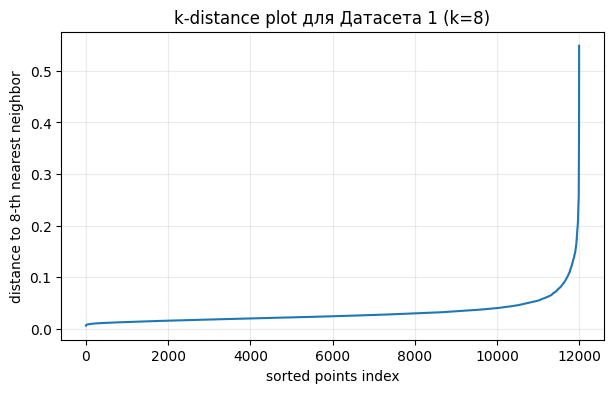

In [44]:
kth = k_distance_plot(X_2d, k=8, title="k-distance plot для Датасета 1")

In [45]:
eps = 0.075
dbscan_model1 = DBSCAN(eps=eps, min_samples=8)
labels = dbscan_model1.fit_predict(X_2d)

summarize_labels(labels), safe_internal_metrics(X_2d, labels)

({'n_points': 12000,
  'n_clusters': 4,
  'n_noise': 322,
  'noise_share': 0.026833333333333334},
 {'silhouette': 0.7212124993378766,
  'calinski_harabasz': 129169.8168301153,
  'davies_bouldin': 0.3486801034700521})

График сохранен: artifacts/figures/dbscan_ds1


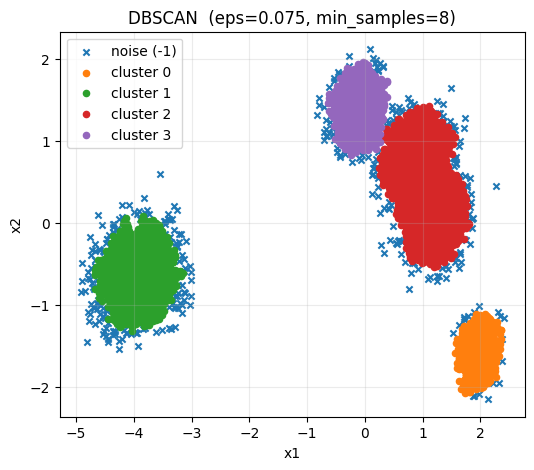

In [46]:
plot_dbscan(X_2d, 
            labels, 
            title=f"DBSCAN  (eps={eps}, min_samples={8})", 
            save_name="dbscan_ds1")
plt.show()

In [47]:
for k in range(2, 21):
    mean_ari, std_ari = check_stability(processed_ds1, k=k)
    print(f"Для K={k}: Средний ARI = {mean_ari:.3f} (±{std_ari:.3f})")

Для K=2: Средний ARI = 1.000 (±0.000)
Для K=3: Средний ARI = 1.000 (±0.000)
Для K=4: Средний ARI = 1.000 (±0.000)
Для K=5: Средний ARI = 0.999 (±0.001)
Для K=6: Средний ARI = 0.892 (±0.096)
Для K=7: Средний ARI = 0.778 (±0.101)
Для K=8: Средний ARI = 0.885 (±0.095)
Для K=9: Средний ARI = 0.747 (±0.089)
Для K=10: Средний ARI = 0.846 (±0.066)
Для K=11: Средний ARI = 0.766 (±0.085)
Для K=12: Средний ARI = 0.694 (±0.125)
Для K=13: Средний ARI = 0.611 (±0.133)
Для K=14: Средний ARI = 0.615 (±0.102)
Для K=15: Средний ARI = 0.630 (±0.066)
Для K=16: Средний ARI = 0.601 (±0.082)
Для K=17: Средний ARI = 0.603 (±0.072)
Для K=18: Средний ARI = 0.560 (±0.079)
Для K=19: Средний ARI = 0.583 (±0.071)
Для K=20: Средний ARI = 0.674 (±0.034)


Датасет 2

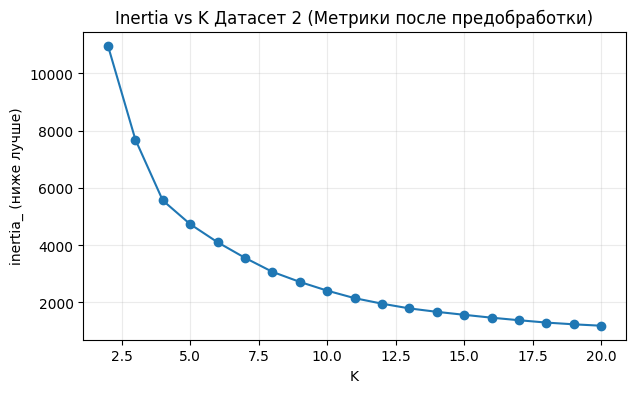

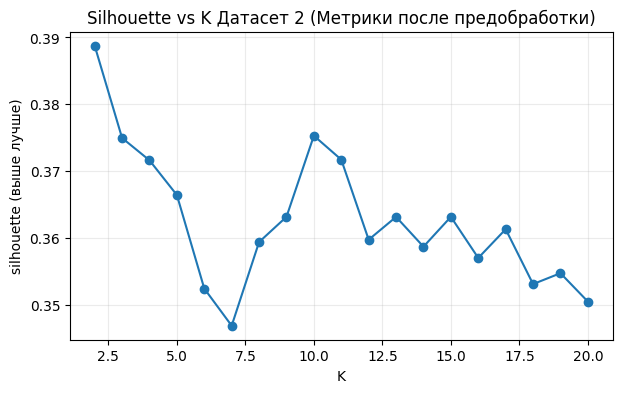

In [48]:
k_values = list(range(2, 21))
pca = PCA(n_components=2)
X_2d = pca.fit_transform(processed_ds2)

metrics_scaled = evaluate_k_range(X_2d, k_values, random_state=42)
plot_k_metrics(metrics_scaled, title_suffix=" Датасет 2 (Метрики после предобработки)")

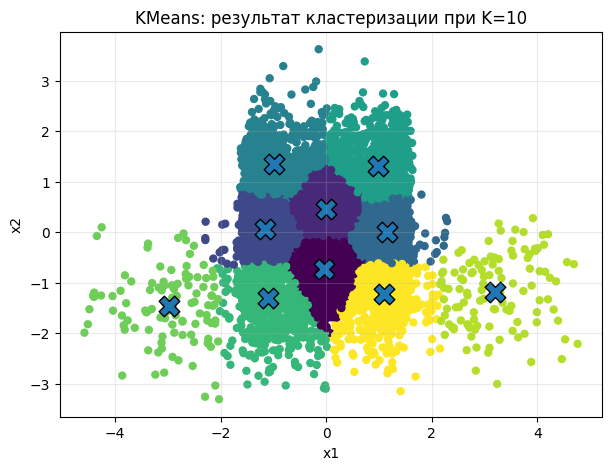

inertia_ = 2413.72
Число найденных кластеров = 10
Внутренние метрики: {'silhouette': 0.12628719497888555, 'calinski_harabasz': 932.264506388584, 'davies_bouldin': 1.869849906370479}


In [49]:
kmeans_model1 = KMeans(n_clusters = 10, n_init=10, random_state=42)
labels = kmeans_model1.fit_predict(X_2d)
metrics = safe_internal_metrics(processed_ds2, labels)

plot_2d_points(
    X_2d, labels=labels, centers=kmeans_model1.cluster_centers_,
    title=f"KMeans: результат кластеризации при K={10}",
    save_name="kmeans_ds2"
)

print("inertia_ =", round(kmeans_model1.inertia_, 2))
print("Число найденных кластеров =", len(np.unique(labels)))
print("Внутренние метрики:", metrics)

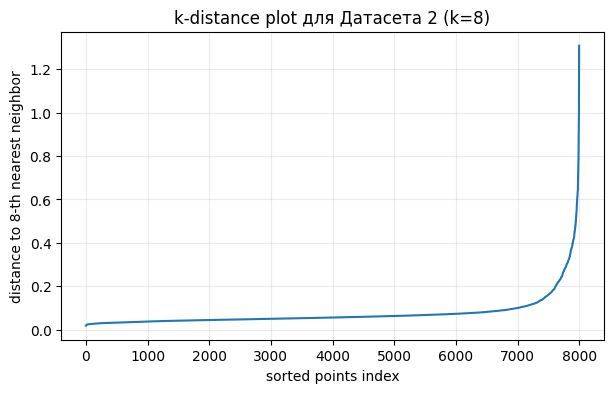

In [50]:
kth = k_distance_plot(X_2d, k=8, title="k-distance plot для Датасета 2")

In [51]:
eps = 0.18
dbscan_model1 = DBSCAN(eps=eps, min_samples=8)
labels = dbscan_model1.fit_predict(X_2d)

summarize_labels(labels), safe_internal_metrics(X_2d, labels)

({'n_points': 8000, 'n_clusters': 3, 'n_noise': 347, 'noise_share': 0.043375},
 {'silhouette': 0.17456997702715385,
  'calinski_harabasz': 31.516883331379862,
  'davies_bouldin': 0.5330575911757395})

График сохранен: artifacts/figures/dbscan_ds2


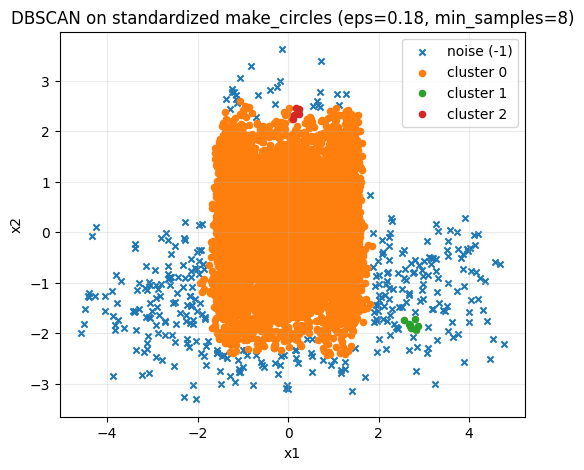

In [52]:
plot_dbscan(X_2d, 
            labels, 
            title=f"DBSCAN on standardized make_circles (eps={eps}, min_samples={8})",
            save_name="dbscan_ds2")
plt.show()

In [53]:
for k in range(2, 21):
    mean_ari, std_ari = check_stability(processed_ds2, k=k)
    print(f"Для K={k}: Средний ARI = {mean_ari:.3f} (±{std_ari:.3f})")

Для K=2: Средний ARI = 0.997 (±0.001)
Для K=3: Средний ARI = 0.987 (±0.007)
Для K=4: Средний ARI = 0.991 (±0.005)
Для K=5: Средний ARI = 0.993 (±0.005)
Для K=6: Средний ARI = 0.924 (±0.062)
Для K=7: Средний ARI = 0.960 (±0.026)
Для K=8: Средний ARI = 0.672 (±0.277)
Для K=9: Средний ARI = 0.805 (±0.164)
Для K=10: Средний ARI = 0.979 (±0.006)
Для K=11: Средний ARI = 0.939 (±0.020)
Для K=12: Средний ARI = 0.951 (±0.030)
Для K=13: Средний ARI = 0.777 (±0.087)
Для K=14: Средний ARI = 0.747 (±0.114)
Для K=15: Средний ARI = 0.683 (±0.110)
Для K=16: Средний ARI = 0.622 (±0.070)
Для K=17: Средний ARI = 0.624 (±0.121)
Для K=18: Средний ARI = 0.655 (±0.110)
Для K=19: Средний ARI = 0.606 (±0.086)
Для K=20: Средний ARI = 0.684 (±0.060)


Датасет 3

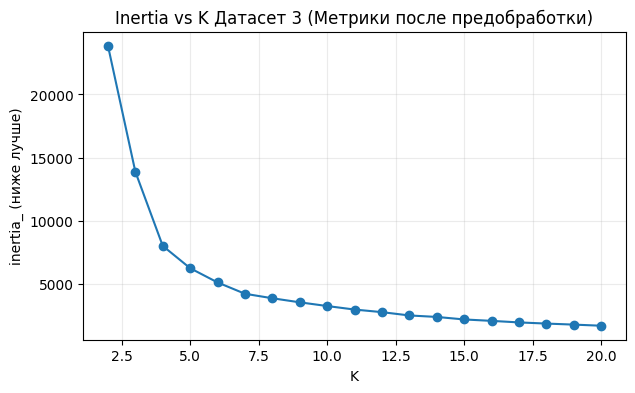

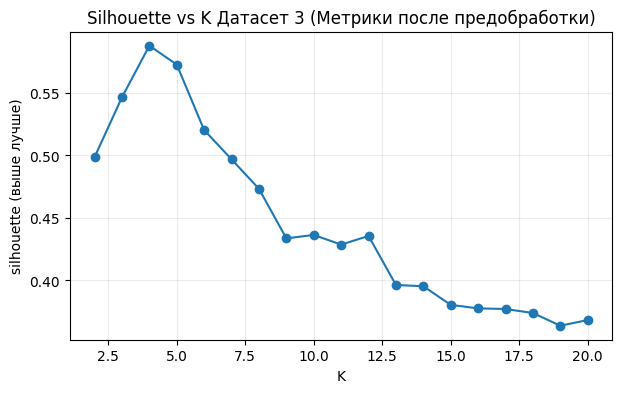

In [54]:
k_values = list(range(2, 21))
pca = PCA(n_components=2)
X_2d = pca.fit_transform(processed_ds3)

metrics_scaled = evaluate_k_range(X_2d, k_values, random_state=42)
plot_k_metrics(metrics_scaled, title_suffix=" Датасет 3 (Метрики после предобработки)")

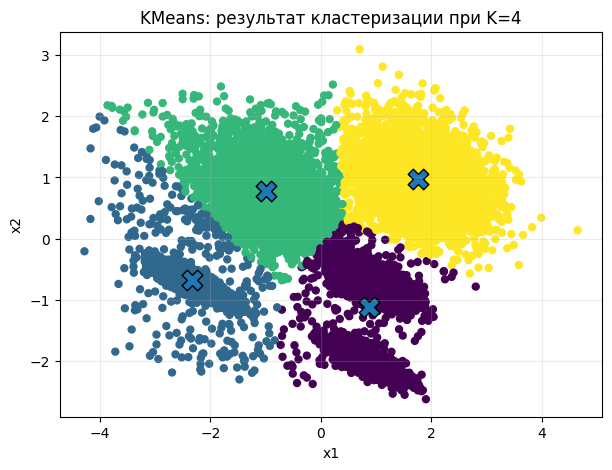

inertia_ = 7998.9
Число найденных кластеров = 4
Внутренние метрики: {'silhouette': 0.33519139123048636, 'calinski_harabasz': 7168.213274189978, 'davies_bouldin': 1.2031394296825058}


In [55]:
kmeans_model1 = KMeans(n_clusters = 4, n_init=10, random_state=42)
labels = kmeans_model1.fit_predict(X_2d)
metrics = safe_internal_metrics(processed_ds3, labels)

plot_2d_points(
    X_2d, labels=labels, centers=kmeans_model1.cluster_centers_,
    title=f"KMeans: результат кластеризации при K={4}",
    save_name="kmeans_ds3"
)

print("inertia_ =", round(kmeans_model1.inertia_, 2))
print("Число найденных кластеров =", len(np.unique(labels)))
print("Внутренние метрики:", metrics)

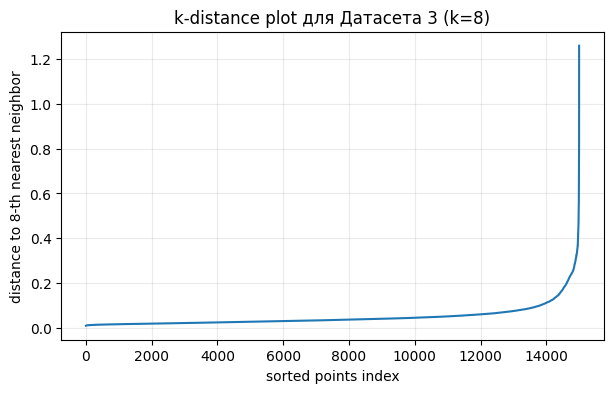

In [56]:
kth = k_distance_plot(X_2d, k=8, title="k-distance plot для Датасета 3")

In [57]:
eps = 0.21
dbscan_model1 = DBSCAN(eps=eps, min_samples=8)
labels = dbscan_model1.fit_predict(X_2d)

summarize_labels(labels), safe_internal_metrics(X_2d, labels)

({'n_points': 15000,
  'n_clusters': 7,
  'n_noise': 187,
  'noise_share': 0.012466666666666666},
 {'silhouette': -0.09117760843501711,
  'calinski_harabasz': 480.32449529314545,
  'davies_bouldin': 0.8651652699165207})

График сохранен: artifacts/figures/dbscan_ds2


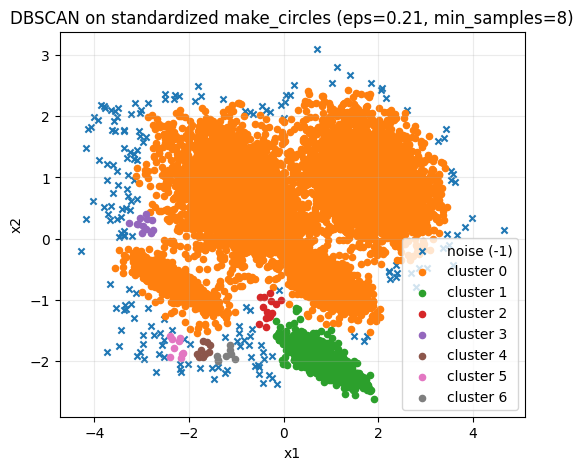

In [58]:
plot_dbscan(X_2d, 
            labels, 
            title=f"DBSCAN on standardized make_circles (eps={eps}, min_samples={8})", 
            save_name="dbscan_ds2")
plt.show()

In [59]:
for k in range(2, 21):
    mean_ari, std_ari = check_stability(processed_ds3, k=k)
    print(f"Для K={k}: Средний ARI = {mean_ari:.3f} (±{std_ari:.3f})")

Для K=2: Средний ARI = 1.000 (±0.000)
Для K=3: Средний ARI = 1.000 (±0.000)
Для K=4: Средний ARI = 1.000 (±0.000)
Для K=5: Средний ARI = 1.000 (±0.000)
Для K=6: Средний ARI = 0.989 (±0.011)
Для K=7: Средний ARI = 0.995 (±0.002)
Для K=8: Средний ARI = 0.994 (±0.003)
Для K=9: Средний ARI = 0.902 (±0.099)
Для K=10: Средний ARI = 0.972 (±0.016)
Для K=11: Средний ARI = 0.871 (±0.068)
Для K=12: Средний ARI = 0.875 (±0.086)
Для K=13: Средний ARI = 0.789 (±0.081)
Для K=14: Средний ARI = 0.914 (±0.055)
Для K=15: Средний ARI = 0.792 (±0.099)
Для K=16: Средний ARI = 0.772 (±0.100)
Для K=17: Средний ARI = 0.858 (±0.086)
Для K=18: Средний ARI = 0.899 (±0.088)
Для K=19: Средний ARI = 0.816 (±0.046)
Для K=20: Средний ARI = 0.798 (±0.077)


In [60]:
import os
import json
from typing import Dict, Any, Union, Optional, Callable
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA  # Добавлен импорт

def save_labels_csv(labels, out_path: str):
    df = pd.DataFrame({"sample_id": np.arange(len(labels)), "cluster_label": labels})
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    df.to_csv(out_path, index=False)

def parse_configs_and_save_labels(
    best_configs_path: str,
    data_dict: Dict[str, Union[np.ndarray, pd.DataFrame]],
    labels_dir: str = "artifacts/labels",
    dataset_key_to_filename: Optional[Union[Callable[[str], str], Dict[str, str]]] = None,
    random_state: int = 42
) -> Dict[str, str]:
    """
    Прочитать best_configs.json и для каждой записи обучить указанную лучшую модель
    на PCA-трансформированных данных (2 компоненты) и сохранить CSV labels.
    """
    
    # Загрузка конфигов
    with open(best_configs_path, "r", encoding="utf-8") as f:
        cfg_all = json.load(f)

    def default_map(key: str) -> str:
        # Исправлено: dataset_1 -> ds1 (чтобы итоговое имя было labels_hw07_ds1.csv)
        if key.startswith("dataset_"):
            return key.replace("dataset_", "ds")
        return key.replace(" ", "_").replace("/", "_")

    mapper = dataset_key_to_filename or default_map

    saved_paths = {}
    
    for ds_key, cfg in cfg_all.items():
        if ds_key not in data_dict:
            raise KeyError(f"Data for '{ds_key}' not provided in data_dict")

        X = data_dict[ds_key]
        
        # Конвертация в numpy
        if isinstance(X, pd.DataFrame):
            X_np = X.values
        else:
            X_np = np.asarray(X)

        # --- ВНЕДРЕНИЕ PCA ---
        # Сжимаем размерность до 2 перед кластеризацией
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X_np)
        # ---------------------

        model_name = cfg.get("best_model", "")
        params = cfg.get("initial_params", {})

        model_name_l = model_name.strip().lower()
        
        # Инициализация модели
        if "kmeans" in model_name_l:
            k = params.get("k")
            if k is None:
                raise ValueError(f"KMeans selected for {ds_key} but 'k' not found")
            model = KMeans(n_clusters=int(k), random_state=random_state)
            
        elif "dbscan" in model_name_l:
            eps = params.get("eps")
            if eps is None:
                raise ValueError(f"DBSCAN selected for {ds_key} but 'eps' not found")
            min_samples = int(params.get("min_samples", 5))
            model = DBSCAN(eps=float(eps), min_samples=min_samples)
            
        else:
            raise ValueError(f"Unsupported model '{model_name}' for dataset '{ds_key}'")

        # Обучение и предсказание НА СЖАТЫХ ДАННЫХ (X_2d)
        labels = model.fit_predict(X_2d)

        # Формирование имени файла
        if callable(mapper):
            suffix = mapper(ds_key)
        elif isinstance(mapper, dict):
            suffix = mapper.get(ds_key, default_map(ds_key))
        else:
            suffix = default_map(ds_key)
            
        fname = f"labels_hw07_{suffix}.csv"
        out_path = os.path.join(labels_dir, fname)
        
        save_labels_csv(labels, out_path)
        saved_paths[ds_key] = out_path

    return saved_paths

In [61]:
data = {
    "dataset_1": processed_ds1,
    "dataset_2": processed_ds2,
    "dataset_3": processed_ds3
}

saved = parse_configs_and_save_labels("artifacts/best_configs.json", data)
print("Saved label files:", saved)

Saved label files: {'dataset_1': 'artifacts/labels\\labels_hw07_ds1.csv', 'dataset_2': 'artifacts/labels\\labels_hw07_ds2.csv', 'dataset_3': 'artifacts/labels\\labels_hw07_ds3.csv'}
